In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv(path + "\stocks_data.csv", index_col = "Date").iloc[1:]

### Доходности акций

In [4]:
df1 = (data - data.shift()).iloc[1:]
df2 = (data.shift()).iloc[1:]
all_returns = df1.div(df2)

In [5]:
rj = all_returns.mean()

### Матрица ковариаций

In [6]:
covars = all_returns.cov()

In [7]:
N = data.shape[1]
T = data.shape[0] - 1
epsilon = -0.2
delta = 0.15
rc = 0.04
h = np.zeros(N)
h[[1,6,8,16]] = 0.02
K = 17
l = 0.7
Tp = 0.5 #time period - данные за полгода

### Option pricing

In [8]:
strikeP = data.iloc[0] * np.exp(-rc * Tp)

In [9]:
Oput = np.exp(- rc * Tp) * np.max(np.transpose([strikeP - data.iloc[-1], np.zeros(N)]), axis = 1)
Ocall = np.exp(- rc * Tp) * np.max(np.transpose([data.iloc[-1] - strikeP, np.zeros(N)]), axis = 1)
O = Ocall + Oput

In [10]:
Vput = np.max(np.transpose([strikeP - data.iloc[-1], np.zeros(N)]), axis = 1)
Vcall = np.max(np.transpose([data.iloc[-1] - strikeP, np.zeros(N)]), axis = 1)

In [11]:
Rput = np.max(np.transpose([data.iloc[0] * np.exp(-rc * Tp) - data.iloc[-1], np.zeros(N)]), axis = 1)/data.iloc[0]
Rcall = np.max(np.transpose([data.iloc[-1] - data.iloc[0] * np.exp(-rc * Tp), np.zeros(N)]), axis = 1)/data.iloc[0]

In [12]:
def create_constr_options(N, T, rj, rc, returns, epsilon, delta, K):
    constr1 =  np.concatenate(((returns - rj).values, np.identity(T), np.zeros((T, N)), np.zeros((T, N))), axis = 1)
    constr2 =  np.concatenate((-(returns - rj).values, np.identity(T), np.zeros((T, N)), np.zeros((T,N))), axis = 1)
    constr3 = np.concatenate((np.ones(N), np.zeros(T + N + N)))
    constr4 = np.concatenate((np.zeros(N), np.zeros(T), np.zeros(N), np.ones(N)))
    constr5 = np.concatenate((np.zeros((T, N)), np.identity(T), np.zeros((T, N)), np.zeros((T, N))), axis = 1)
    constr6 = np.concatenate((np.diag(rj), np.zeros((N, T + N + N))), axis = 1)
    constr7_1 = np.concatenate((np.identity(N), np.zeros((N, T)), np.zeros((N, N)), -epsilon * np.identity(N)), axis = 1)
    constr7_2 = np.concatenate((np.identity(N), np.zeros((N, T)), np.zeros((N, N)), -delta * np.identity(N)), axis = 1)
    constr8 = np.concatenate((np.identity(N), np.zeros((N, T)), np.identity(N), np.zeros((N, N))), axis = 1)
    constr9 = np.concatenate((-1 * np.identity(N), np.zeros((N, T)), np.identity(N), np.zeros((N, N))), axis = 1)
    constr10 = np.concatenate((np.zeros((N, N)), np.zeros((N, T)), np.identity(N), np.zeros((N, N))), axis = 1)
    
    
    constr = np.concatenate((constr1, constr2, [constr3], [constr4], constr5, constr6, constr7_1, constr7_2, constr8, constr9, constr10))
    
    rhs1 = np.concatenate((np.zeros(T + T), [1, K], np.zeros(T), np.zeros(N), np.zeros(N + N), np.zeros(N + N + N)))
    rhs2 = np.concatenate((np.ones(T + T), [0, 0], np.ones(T), np.ones(N), np.ones(N), np.full(N, -1), np.ones(N + N + N)))
    rhs = np.array([rhs1, rhs2]).T
    
    return constr, rhs

In [13]:
def create_obj(N, T, rj, rc, h, Rcall, Rput, O, l):
    return np.concatenate((-(1 - l) * ((rj.values - rc*h) + (Rcall + Rput).values), np.full(T, l/T), (1 - l) * (O/ data.iloc[0]), np.zeros(N)))

In [14]:
import pyomo.environ as pyo

model_o = pyo.AbstractModel()

model_o.m = pyo.Param(within=pyo.NonNegativeIntegers) #количество ограничений
model_o.n = pyo.Param(within=pyo.NonNegativeIntegers) #количество переменных всего 
model_o.nx = pyo.Param(within=pyo.NonNegativeIntegers) #количество обычных переменных
model_o.nz = pyo.Param(within=pyo.NonNegativeIntegers) #количество бинарных переменных
model_o.right = pyo.RangeSet(1, 2)

model_o.I = pyo.RangeSet(1, model_o.m) #индексы ограничений
model_o.J = pyo.RangeSet(1, model_o.n) #индексы переменных
model_o.Jx = pyo.RangeSet(1, model_o.nx) #индексы обычных переменных
model_o.Jz = pyo.RangeSet(1, model_o.nz) #индексы бинарных переменных

model_o.Ax = pyo.Param(model_o.I, model_o.Jx) #объявляем матрицу ограничений для x
model_o.Az = pyo.Param(model_o.I, model_o.Jz) #объявляем матрицу ограничений для z
model_o.rhs = pyo.Param(model_o.I, model_o.right) #rhs
model_o.c = pyo.Param(model_o.Jx)

model_o.x = pyo.Var(model_o.Jx, domain = pyo.Reals)
model_o.z = pyo.Var(model_o.Jz, domain = pyo.Binary)

def obj_expression(m):
    return pyo.summation(m.c, m.x)
    #return l/T*sum(m.x[-T:]) - (1 - l) * np.dot((rj.values - rc*h), m.x[:N])

model_o.OBJ = pyo.Objective(rule=obj_expression)

def constraint_rule(m, i):
    if m.rhs[i,2] == -1:
        return sum(m.Ax[i,j] * m.x[j] for j in m.Jx) + sum(m.Az[i,j] * m.z[j] for j in m.Jz) <= m.rhs[i,1]
    if m.rhs[i,2] == 0:
        return sum(m.Ax[i,j] * m.x[j] for j in m.Jx) + sum(m.Az[i,j] * m.z[j] for j in m.Jz) == m.rhs[i,1]
    if m.rhs[i,2] == 1:
        return sum(m.Ax[i,j] * m.x[j] for j in m.Jx) + sum(m.Az[i,j] * m.z[j] for j in m.Jz) >=m.rhs[i,1]
    
model_o.constraints = pyo.Constraint(model_o.I, rule = constraint_rule)

In [15]:
def solve_o(m, n, nx, nz, c, A, rhs):
    rules = {None:{
        'm': {None: m},
        'n': {None: n},
        'nx': {None: nx},
        'nz': {None: nz},
        'Ax': {(i + 1, j + 1): A[i][j] for i in range(m) for j in range(nx)},
        'Az': {(i + 1, j + 1): A[i][j + nx] for i in range(m) for j in range(nz)},
        'rhs': {(i + 1, j + 1): rhs[i][j] for i in range(m) for j in range(2)},
        'c': {i + 1: c[i] for i in range(nx)}
        }}
    ins = model_o.create_instance(rules)
    opt = pyo.SolverFactory('glpk')
    opt.solve(ins)
    res = [pyo.value(ins.x[i]) for i in range(1, nx+1)]
    bins = [pyo.value(ins.z[i]) for i in range(1, nz+1)]
    return res, bins

### Оптимизация

In [16]:
constr, rhs = create_constr_options(N, T, rj, rc, all_returns, -0.3, 0.3, 20)
m = constr.shape[0]
n = constr.shape[1]
nz = N
nx = n - nz

In [17]:
c_options = create_obj(N, T, rj, rc, h, Rcall, Rput, O, 0.5)

In [20]:
res, bins = solve_o(m, n, nx, nz, c_options, constr, rhs)
weights = res[:N]

In [96]:
option_return(Rput, Rcall, O, weights)

0.005321705652927

### Стандартное отклонение портфеля, в процентах:

In [22]:
def stdev(weights, covars):
    return np.sqrt(np.dot(np.dot(np.transpose(weights), covars), np.array(weights)))

In [23]:
np.sqrt(np.dot(np.dot(np.transpose(weights), covars), np.array(weights)))

0.010175262371944264

### Доходность портфеля, в процентах:

In [24]:
def option_return(Rput, Rcall, O, weights):
    return np.dot((Rcall + Rput).values, np.abs(weights)) - np.dot(O/data.iloc[0], np.abs(weights))

In [25]:
option_return(Rput, Rcall, O, weights)

0.006157813651302579

# Сравнение алгоритмов

## Изменяя $\lambda$

In [30]:
lambdas = np.arange(0, 1.1, 0.1)
K = 20
l_o = []
constr, rhs = create_constr_options(N, T, rj, rc, all_returns, -0.2, 0.15, K)
m = constr.shape[0]
n = constr.shape[1]
nz = N
nx = n - nz
for l in lambdas:
    c_options = create_obj(N, T, rj, rc, h, Rcall, Rput, O, l)
    res, bins = solve_o(m, n, nx, nz, c_options, constr, rhs)
    weights = res[:N]
    l_o.append([K, l, option_return(Rput, Rcall, O, weights), stdev(weights, covars)])
    
    

l_o = np.array(l_o)
l_o = np.concatenate([[np.array( [1.70000000e+01, 0.00000000e+00,5.26386155e-03 , 1.72061690e-02])], l_o])

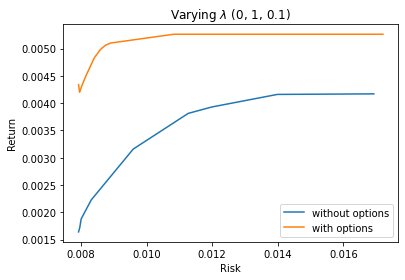

In [39]:
plt.plot(l_wo[:, 3], l_wo[:, 2], label = 'without options')
plt.plot(l_o[:, 3], l_o[:, 2], label = 'with options')
plt.xlabel("Risk")
plt.ylabel("Return")
plt.title("Varying $\lambda$ (0, 1, 0.1)")
plt.legend()
plt.show()

In [32]:
l_wo = np.array([[1.70000000e+01, 0.00000000e+00, 4.17086006e-03, 1.69299200e-02],
       [1.70000000e+01, 1.00000000e-01, 4.16070518e-03, 1.39872580e-02],
       [1.70000000e+01, 2.00000000e-01, 3.93112312e-03, 1.19961480e-02],
       [1.70000000e+01, 3.00000000e-01, 3.81325529e-03, 1.12715812e-02],
       [1.70000000e+01, 4.00000000e-01, 3.15842091e-03, 9.59326378e-03],
       [1.70000000e+01, 5.00000000e-01, 2.22683065e-03, 8.31470704e-03],
       [1.70000000e+01, 6.00000000e-01, 1.87843755e-03, 8.00699115e-03],
       [1.70000000e+01, 7.00000000e-01, 1.72622445e-03, 7.96644970e-03],
       [1.70000000e+01, 8.00000000e-01, 1.72566552e-03, 7.96741763e-03],
       [1.70000000e+01, 9.00000000e-01, 1.64007315e-03, 7.92708417e-03],
       [1.70000000e+01, 1.00000000e+00, 1.64007315e-03, 7.92708417e-03]])

In [37]:
l_o = np.array([[1.70000000e+01, 0.00000000e+00, 5.26386155e-03, 1.72061690e-02],
       [2.00000000e+01, 0.00000000e+00, 5.26386155e-03, 1.08312882e-02],
       [2.00000000e+01, 1.00000000e-01, 5.26386155e-03, 1.08312882e-02],
       [2.00000000e+01, 2.00000000e-01, 5.10279785e-03, 8.90821361e-03],
       [2.00000000e+01, 3.00000000e-01, 5.06694041e-03, 8.76361116e-03],
       [2.00000000e+01, 4.00000000e-01, 5.01391751e-03, 8.64949919e-03],
       [2.00000000e+01, 5.00000000e-01, 4.97641204e-03, 8.58365866e-03],
       [2.00000000e+01, 6.00000000e-01, 4.83199574e-03, 8.40868793e-03],
       [2.00000000e+01, 7.00000000e-01, 4.51200284e-03, 8.16013578e-03],
       [2.00000000e+01, 8.00000000e-01, 4.32522965e-03, 8.03151356e-03],
       [2.00000000e+01, 9.00000000e-01, 4.19989669e-03, 7.95949025e-03],
       [2.00000000e+01, 1.00000000e+00, 4.33998844e-03, 7.92708417e-03]])

In [38]:
(pd.concat([pd.DataFrame(l_wo), pd.DataFrame(l_o)], axis = 1)).to_excel(path + "\portfoliosMAD.xlsx")